# Preprocessing the data

In [7]:
import LoadUtils
import pandas as pd

PATH_BUSINESS = "../yelp_dataset/yelp_academic_dataset_business.json"
PATH_REVIEW = "../yelp_dataset/yelp_academic_dataset_review.json"

In [5]:
# Recommend to set to a low value like 100,000 for quicker iteration.
# Set to -1 to load the full files, which will make processing SIGNIFICANTLY slower.
N_LINES = 1000000

In [8]:
# Filter for OPEN ONLY businesses in California
data_business = LoadUtils.load_matches(PATH_BUSINESS, n_lines=N_LINES, verbose=True,
                                       func=LoadUtils.fn_all,
                                       args=[(LoadUtils.fn_eq, "state", "CA"),
                                             (LoadUtils.fn_eq, "is_open", 1)])
business_ca_open = pd.DataFrame(data_business)

# Display filtered data
print(f"Number of open businesses in California: {business_ca_open.shape[0]}")
print(business_ca_open.head())

Now loading ../yelp_dataset/yelp_academic_dataset_business.json
[====] Loaded 4065/150345 entries (0 unprocessable)
Number of open businesses in California: 4065
              business_id                             name  \
0  noByYNtDLQAra9ccqxdfDw                              H&M   
1  IDtLPgUrqorrpqSLdfMhZQ             Helena Avenue Bakery   
2  nUqrF-h9S7myCcvNDecOvw             Iron Horse Auto Body   
3  bYjnX_J1bHZob10DoSFkqQ      Tinkle Belle Diaper Service   
4  SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company   

                 address           city state postal_code   latitude  \
0       827-833 State St  Santa Barbara    CA       93101  34.420209   
1  131 Anacapa St, Ste C  Santa Barbara    CA       93101  34.414445   
2         825 Cacique St  Santa Barbara    CA       93103  34.419620   
3                         Santa Barbara    CA       93101  34.420334   
4      230 Stearns Wharf  Santa Barbara    CA       93101  34.408715   

    longitude  stars  review_cou

In [9]:
biz_ids = set()
for item in data_business:
    biz_ids.add(item["business_id"])

# full data is 7 million entries, so this takes pretty long (around 3 minutes)
data_review = LoadUtils.load_matches(PATH_REVIEW, n_lines=N_LINES, verbose=True,
                                     func=LoadUtils.fn_in,
                                     args=("business_id", biz_ids))

Now loading ../yelp_dataset/yelp_academic_dataset_review.json
[====================] Loaded 38940/1000000 entries (0 unprocessable)


In [29]:
df_review = pd.DataFrame(data_review)
review_ca_open = df_review.merge(business_ca_open[['business_id', 'name', 'categories']], on='business_id')

# Display filtered reviews
print(f"Number of reviews for open businesses in California: {review_ca_open.shape[0]}")
print(f"These reviews span {len(set(review_ca_open['business_id']))} unique businesses")
print(review_ca_open.head())

Number of reviews for open businesses in California: 38940
These reviews span 704 unique businesses
                review_id                 user_id             business_id  \
0  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
1  pUycOfUwM8vqX7KjRRhUEA  59MxRhNVhU9MYndMkz0wtw  gebiRewfieSdtt17PTW6Zg   
2  eCiWBf1CJ0Zdv1uVarEhhw  OhECKhQEexFypOMY6kypRw  vC2qm1y3Au5czBtbhc-DNw   
3  YbMyvlDA2W3Py5lTz8VK-A  4hBhtCSgoxkrFgHa4YAD-w  bbEXAEFr4RYHLlZ-HFssTA   
4  L0jv8c2FbpWSlfNC6bbUEA  bFPdtzu11Oi0f92EAcjqmg  IDtLPgUrqorrpqSLdfMhZQ   

   stars  useful  funny  cool  \
0    3.0       1      1     0   
1    3.0       0      0     0   
2    4.0       0      0     0   
3    5.0       0      0     0   
4    5.0       0      0     0   

                                                text                 date  \
0  This easter instead of going to Lopez Lake we ...  2016-03-30 22:46:33   
1  Had a party of 6 here for hibachi. Our waitres...  2016-07-25 07:31:06   
2  Yes,

In [11]:
# this cell takes pretty long on larger data, 4-5 minutes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Convert the textual reviews into a numerical representation using TF-IDF (Term Frequency-Inverse Document Frequency)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to 5000 most important terms
review_tfidf = tfidf.fit_transform(review_ca_open['text'])

print(f"TF-IDF Matrix Shape: {review_tfidf.shape}")  # High-dimensional representation

# Apply Dimentionality Reduction using Principal Component Analysis (PCA)
pca = PCA(n_components=50)  # Reduce to 50 components
reduced_reviews = pca.fit_transform(review_tfidf.toarray())

print(f"Reduced Dimensions Shape: {reduced_reviews.shape}")  # Lower-dimensional representation

TF-IDF Matrix Shape: (38940, 5000)
Reduced Dimensions Shape: (38940, 50)


# Clustering

In [13]:
# Associate reduced review features with businesses
business_features = pd.DataFrame(reduced_reviews, columns=[f'PC{i+1}' for i in range(reduced_reviews.shape[1])])
business_features['business_id'] = review_ca_open['business_id'].values

Now clustering with k= 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29...

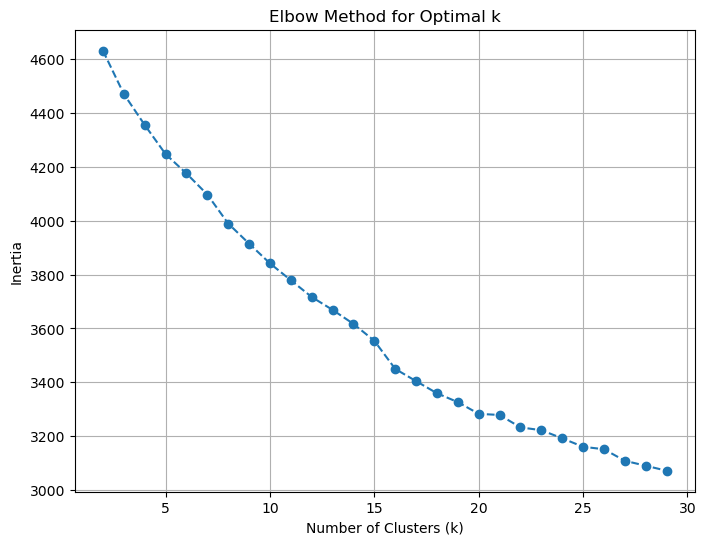

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the best number of clusters using Elbow Method
inertia = []
k_values = range(2, 30)

print("Now clustering with k=", end='')
for k in k_values:
    print(f" {k}...", end='')
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(business_features.drop(columns=['business_id']))
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [15]:
# Apply K-Means with the chosen number of clusters based on the Elbow Curve
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
business_features['cluster'] = kmeans.fit_predict(business_features.drop(columns=['business_id']))

# get each business id's most popular cluster
biz_cluster = {"business_id": [], "cluster": []}
for biz_id in set(business_features["business_id"]):
    item = business_features[business_features["business_id"] == biz_id]
    x = item["cluster"].value_counts().index[0]
    biz_cluster["business_id"].append(biz_id)
    biz_cluster["cluster"].append(x)

# Merge cluster labels back to business data
df_biz_cluster = pd.DataFrame(biz_cluster)
business_clusters = business_ca_open[['business_id', 'name', 'categories']].merge(
    df_biz_cluster, on='business_id'
)

# Display sample results
print(business_clusters.head())

              business_id                             name  \
0  noByYNtDLQAra9ccqxdfDw                              H&M   
1  IDtLPgUrqorrpqSLdfMhZQ             Helena Avenue Bakery   
2  nUqrF-h9S7myCcvNDecOvw             Iron Horse Auto Body   
3  bYjnX_J1bHZob10DoSFkqQ      Tinkle Belle Diaper Service   
4  SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company   

                                          categories  cluster  
0  Women's Clothing, Accessories, Children's Clot...        2  
1  Food, Restaurants, Salad, Coffee & Tea, Breakf...        3  
2                     Towing, Automotive, Body Shops        2  
3  Parenting Classes, Maternity Wear, Fashion, Ed...        2  
4  Live/Raw Food, Restaurants, Seafood, Beer Bar,...        9  


# Output

In [16]:
# Merge user reviews with clusters to determine user interactions
user_cluster_data = review_ca_open.merge(
    business_clusters[['business_id', 'cluster']],
    on='business_id')

# Assign users to their most-interacted cluster
user_cluster_pref = user_cluster_data.groupby(['user_id', 'cluster']).size().reset_index(name='review_count')

# Find the cluster with the highest review count for each user
user_pref_cluster = user_cluster_pref.loc[
    user_cluster_pref.groupby('user_id')['review_count'].idxmax()
].rename(columns={'cluster': 'preferred_cluster'})

# Recommend businesses from the preferred cluster
def recommend_businesses(user_id, num_recommendations=5):
    # Check if the user exists in the preference data
    if user_id not in user_pref_cluster['user_id'].values:
        return f"User {user_id} has no interactions recorded."

    # Get the user's preferred cluster
    preferred_cluster = user_pref_cluster[user_pref_cluster['user_id'] == user_id]['preferred_cluster'].values[0]
    
    # Get all businesses in this cluster
    cluster_businesses = business_clusters[business_clusters['cluster'] == preferred_cluster]
    
    # Exclude businesses the user has already reviewed
    reviewed_businesses = user_cluster_data[user_cluster_data['user_id'] == user_id]['business_id'].unique()
    recommendations = cluster_businesses[~cluster_businesses['business_id'].isin(reviewed_businesses)]
    
    # Select top businesses for recommendation (or fewer if less available)
    return recommendations[['name', 'categories']].sample(n=min(num_recommendations, len(recommendations)))

In [75]:
ILOC = 420

user_id_example = user_pref_cluster['user_id'].iloc[ILOC]
user_id_example = 'riHD8z9hzOfzwUsBPpVKNA'
recommendations = recommend_businesses(user_id_example, num_recommendations=5)
print(f"Recommendations for User {user_id_example}")
recommendations

Recommendations for User riHD8z9hzOfzwUsBPpVKNA


,name,categories
8,Marty's Pizza,"Pizza, Restaurants"
242,Backyard Bowls,"Health Markets, Coffee & Tea, Ice Cream & Froz..."
467,Sam's To Go,"Sandwiches, Restaurants, American (New)"
345,Third Window Brewing,"Nightlife, Beer Gardens, Breweries, Food, Beer..."
218,Cristino's Bakery,"Mexican, Restaurants, Bakeries, Food, Sandwich..."


# Random Forest Attempt

In [40]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for review text
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']
review_data = review_ca_open
# Add sentiment score to the dataset
review_data['review_sentiment'] = review_data['text'].apply(get_sentiment_score)

In [ ]:
# Processing business categories (one-hot encoding)
category_data = review_data[['business_id', 'name', 'categories']].drop_duplicates()
category_data['categories'] = category_data['categories'].str.split(', ')  # Split the comma-separated categories

# Expand categories into separate rows (one for each category)
category_expanded = category_data.explode('categories')

# One-hot encode categories
category_dummies = pd.get_dummies(category_expanded['categories'], prefix='category')
category_dummies['business_id'] = category_expanded['business_id'].values

# Aggregate back to business level (sum category dummies for each business)
business_category_features = category_dummies.groupby('business_id').sum().reset_index()

# Merge business features with category dummies
business_features = review_data.merge(business_category_features, on='business_id', how='left')
business_features.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,category_Window Washing,category_Windows Installation,category_Wine & Spirits,category_Wine Bars,category_Wine Tasting Classes,category_Wine Tasting Room,category_Wine Tours,category_Wineries,category_Women's Clothing,category_Yoga
0,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,Los Padres National Forest,...,0,0,0,0,0,0,0,0,0,0
1,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,Hibachi Steak House & Sushi Bar,...,0,0,0,0,0,0,0,0,0,0
2,eCiWBf1CJ0Zdv1uVarEhhw,OhECKhQEexFypOMY6kypRw,vC2qm1y3Au5czBtbhc-DNw,4.0,0,0,0,"Yes, this is the only sushi place in town. How...",2013-09-04 03:48:20,Sushi Teri,...,0,0,0,0,0,0,0,0,0,0
3,YbMyvlDA2W3Py5lTz8VK-A,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5.0,0,0,0,"Great burgers,fries and salad! Burgers have a...",2017-01-02 03:17:34,The Original Habit Burger Grill,...,0,0,0,0,0,0,0,0,0,0
4,L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5.0,0,0,0,What a great addition to the Funk Zone! Grab ...,2016-10-13 22:50:47,Helena Avenue Bakery,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Merge user features with business features for interactions
interaction_data = business_features.drop(columns=['useful', 'funny', 'cool', 'text', 'date'])
# Display the first few rows of the interaction data
interaction_data.head()

,review_id,user_id,business_id,stars,name,categories,review_sentiment,category_ATV Rentals/Tours,category_Acai Bowls,category_Accessories,...,category_Window Washing,category_Windows Installation,category_Wine & Spirits,category_Wine Bars,category_Wine Tasting Classes,category_Wine Tasting Room,category_Wine Tours,category_Wineries,category_Women's Clothing,category_Yoga
38935,AUqVe9FX5uZOGUBS6VKAmA,cc6WipNDzRqe_vXl9HOrgw,CUWituEeIX3xA0xU7X82Ow,5.0,Brasil Arts Cafe,"Juice Bars & Smoothies, Breakfast & Brunch, Br...",0.9910,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38936,E9CTw06FXDXhq3_odEfUQA,EVpR158nwXPfAGUZqS4G3g,l0MYvo9VPUN-gnlAhg11UQ,5.0,SB Chauffeuring & Tours,"Transportation, Limos, Wine Tours, Tours, Airp...",0.9306,0,0,0,...,0,0,0,0,0,0,1,0,0,0
38937,B8HEtg_fMOcwszoAD49J6A,FWQu6GMuptvTpUsDwkpOGw,jLn69WQupjsDKrbPw_nlGQ,4.0,Yogurtland Santa Barbara,"Ice Cream & Frozen Yogurt, Food",0.8412,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38938,ay5KyNhqaILKMvD7nTQk4Q,riHD8z9hzOfzwUsBPpVKNA,5RsVAkDnMrcSbErS6P1eew,4.0,Cajé Coffee Roasters - Isla Vista,"Food, Internet Cafes, Coffee & Tea, Acai Bowls...",0.8873,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38939,t-2o35kr7Q9DSaeuKhaDuQ,oX7o1TH0PHUWp9r9ry9_vw,jLn69WQupjsDKrbPw_nlGQ,3.0,Yogurtland Santa Barbara,"Ice Cream & Frozen Yogurt, Food",0.3182,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convert ratings to a binary target: 'like' or 'dislike' based on rating (e.g., rating >= 4 means 'like')
interaction_data['liked'] = interaction_data['stars'].apply(lambda x: 1 if x >= 4 else 0)

# Define features: including business categories in the feature set
category_columns = [col for col in interaction_data.columns if col.startswith('category_')]
review_features = ['business_id', 'stars', 'review_sentiment'] + category_columns
user_features = ['user_id', 'stars', 'review_sentiment'] + category_columns
model_features = ['stars', 'review_sentiment'] + category_columns

# Prepare input features (X) and target variable (y)
X = interaction_data[model_features]
y = interaction_data['liked']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')
print(model_features)

Model Accuracy: 99.96%
['stars', 'review_sentiment', 'category_ATV Rentals/Tours', 'category_Acai Bowls', 'category_Accessories', 'category_Accountants', 'category_Acne Treatment', 'category_Active Life', 'category_Acupuncture', 'category_Adult', 'category_Adult Education', 'category_Adult Entertainment', 'category_Advertising', 'category_Air Duct Cleaning', 'category_Airport Shuttles', 'category_Allergists', 'category_Amateur Sports Teams', 'category_American (New)', 'category_American (Traditional)', 'category_Animal Shelters', 'category_Antiques', 'category_Apartments', 'category_Appliances', 'category_Appliances & Repair', 'category_Aquariums', 'category_Arcades', 'category_Art Galleries', 'category_Art Museums', 'category_Art Supplies', 'category_Artificial Turf', 'category_Arts & Crafts', 'category_Arts & Entertainment', 'category_Asian Fusion', 'category_Assisted Living Facilities', 'category_Australian', 'category_Auto Customization', 'category_Auto Detailing', 'category_Auto G

In [74]:
# Prediction
# Assume we have a specific user_id and want to recommend businesses
user_id = 'riHD8z9hzOfzwUsBPpVKNA'  # Example user ID
# user_id = user_pref_cluster['user_id'].iloc[ILOC]

# Filter data for this user and the businesses they have not rated yet
user_data = interaction_data[interaction_data['user_id'] == user_id]
rated_businesses = user_data['business_id'].tolist()
all_businesses = interaction_data['business_id'].tolist()
unrated_businesses = list(set(all_businesses) - set(rated_businesses))

unrated_data = interaction_data[interaction_data['business_id'].isin(unrated_businesses)]


# Make predictions for these businesses
unrated_data['predicted_like'] = rf.predict(unrated_data[model_features])

# Get top recommended businesses (those with highest predicted 'like')
recommended_businesses = unrated_data[unrated_data['predicted_like'] == 1]
print(recommended_businesses[['name', 'business_id', 'categories', 'stars']])

                                           name             business_id  \
2                                    Sushi Teri  vC2qm1y3Au5czBtbhc-DNw   
3               The Original Habit Burger Grill  bbEXAEFr4RYHLlZ-HFssTA   
4                          Helena Avenue Bakery  IDtLPgUrqorrpqSLdfMhZQ   
5                            HOME Santa Barbara  qO9dNNIvNbCBd8ZgjxMxgQ   
6               Santa Barbara Shellfish Company  SZU9c8V2GuREDN5KgyHFJw   
...                                         ...                     ...   
38933                                   Sandbar  EtM079Cj7-B3G7jPsGYb_Q   
38934  Big Brand Tire & Service - Santa Barbara  lnjYuK2sAg8qxTvvlnhNFg   
38935                          Brasil Arts Cafe  CUWituEeIX3xA0xU7X82Ow   
38936                   SB Chauffeuring & Tours  l0MYvo9VPUN-gnlAhg11UQ   
38937                  Yogurtland Santa Barbara  jLn69WQupjsDKrbPw_nlGQ   

                                              categories  stars  
2                                

C:\Users\atomi\AppData\Local\Temp\ipykernel_15076\940450307.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrated_data['predicted_like'] = rf.predict(unrated_data[model_features])
